# Thumbs Up/Down Image Classification

Welcome to the thumbs up/down image classification training script! This was designed to run in Google Colab, but it should (in theory) run in any Jupyter Notebook or Jupyter Lab environment with PyTorch installed.

In Google Colab, select **File > Open notebook** then select the **Upload** tab. Select this file to open it in Colab.

Press **shift + enter** to execute each cell in order. Make sure you stop and read each text section, as there are some manual steps you will need to perform (e.g. upload dataset).

In [1]:
# Install specific versions of the packages
!python3 -m pip install \
    matplotlib=='3.10.0' \
    numpy=='2.0.2' \
    onnxscript=='0.5.7' \
    pandas=='2.2.2' \
    Pillow=='11.3.0' \
    torch=='2.9.0+cpu'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 13.1 MB/s eta 0:00:00


In [2]:
# Import standard libraries
import os
from pathlib import Path
import random
import zipfile

# Import third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# Print out the versions of the libraries
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Pillow version: {Image.__version__}")
print(f"PyTorch version: {torch.__version__}")

Matplotlib version: 3.10.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Pillow version: 11.3.0
PyTorch version: 2.9.0+cpu


In [121]:
# General settings
SEED = 42
DATASET_ZIP_PATH = Path("/content/thumbs_up_down_images.zip")
DATASET_PATH = Path("/content/thumbs_up_down_images")

# Image preprocessing settings
IMG_WIDTH = 48
IMG_HEIGHT = 48

# Grayscale conversion coefficients
GRAY_R_COEFF = 0.299
GRAY_G_COEFF = 0.587
GRAY_B_COEFF = 0.114

# Data settings
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

# Model settings
CONV_1_NUM_FILTERS = 8
CONV_2_NUM_FILTERS = 16
DROPOUT = 0.3
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100

# ONNX export settings
ONNX_OPSET_VERSION = 18
ONNX_PATH = Path("/content/model.onnx")

# Calibration data settings
NUM_CALIB_SAMPLES = 100
CALIB_NPZ_PATH = Path("/content/calibration_data.npz")

In [5]:
 # Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [6]:
# Define the target compute device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Prepare Dataset

You will need to manually upload the image dataset you created. This should include at least 100 samples (BMP format) for each of the 4 classes (_background, _other, thumbs_down, thumbs_up).

First, zip your dataset as follows:

```
thumbs_up_down_dataset.zip
├─ _background/
│  ├─ 0000.BMP
│  ├─ 0001.BMP
│  └─ ...
├─ _other/
│  ├─ 0000.BMP
│  ├─ 0001.BMP
│  └─ ...
├─ thumbs_down/
│  ├─ 0000.BMP
│  ├─ 0001.BMP
│  └─ ...
└─ thumbs_up/
│  ├─ 0000.BMP
│  ├─ 0001.BMP
   └─ ...
```

On the left side, click the **Folder** icon to expand the file browser tab. Click the **Upload** icon. Select the **thumbs_up_down_dataset.zip** file to upload it to this Colab instance.

Once you have uploaded the .zip file, run the following cells to unzip and prepare the dataset.

In [8]:
# Extract the zip file
with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [9]:
# Discover class names based on folder names
class_names = sorted([d for d in os.listdir(DATASET_PATH)
                      if os.path.isdir(os.path.join(DATASET_PATH, d))])
print(f"Class names: {class_names}")

Class names: ['_background', '_other', 'thumbs_down', 'thumbs_up']


In [10]:
# Map an index number to each class name
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
print(class_to_idx)

{'_background': 0, '_other': 1, 'thumbs_down': 2, 'thumbs_up': 3}


In [11]:
def resize_nearest_neighbor(image, new_width, new_height):
    """
    Resize image using nearest-neighbor interpolation
    """
    old_height, old_width = image.shape[:2]

    # Handle grayscale vs RGB
    if len(image.shape) == 3:
        resized = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)
    else:
        resized = np.zeros((new_height, new_width), dtype=image.dtype)

    # Calculate scale factors
    x_scale = old_width / new_width
    y_scale = old_height / new_height

    # Map each new pixel to nearest old pixel
    for y in range(new_height):
        old_y = int(y * y_scale)
        for x in range(new_width):
            old_x = int(x * x_scale)
            resized[y, x] = image[old_y, old_x]

    return resized

In [12]:
def rgb_to_grayscale(image):
    """
    Convert RGB image to grayscale
    """
    gray = (GRAY_R_COEFF * image[:, :, 0] +
            GRAY_G_COEFF * image[:, :, 1] +
            GRAY_B_COEFF * image[:, :, 2])

    return gray.astype(np.uint8)

In [13]:
def preprocess_image(filepath, target_width, target_height):
    """
    Full preprocessing pipeline: load, resize, grayscale
    Returns a (H, W) uint8 array.
    """
    # Load RGB image using PIL
    img = Image.open(filepath).convert('RGB')
    img = np.array(img)

    # Resize using nearest-neighbor
    img = resize_nearest_neighbor(img, target_width, target_height)

    # Convert to grayscale
    img = rgb_to_grayscale(img)

    # Convert to float32 (for PyTorch)
    # We want to keep 0-255 range for INT8 quantization!
    img = img.astype(np.float32)

    return img

In [14]:
# Store preprocessed images and labels
all_data = []
all_labels = []

# Go through each class directory
for class_name in class_names:

    # Construct path to class folder
    class_folder = DATASET_PATH / class_name
    image_files = sorted(os.listdir(class_folder))

    # Load and preprocess each image
    for image_file in image_files:
        if image_file.endswith('.BMP'):
            image_path = class_folder / image_file

            # Preprocess (load, resize, grayscale)
            img = preprocess_image(image_path, IMG_WIDTH, IMG_HEIGHT)

            # Append to lists
            all_data.append(img)
            all_labels.append(class_to_idx[class_name])

# Summary
num_samples = len(all_data)
print(f"Loaded {num_samples} total samples")
print(f"Image shape: {all_data[0].shape}")
print(f"Samples per class:")
for class_name in class_names:
    count = all_labels.count(class_to_idx[class_name])
    print(f"  {class_name}: {count}")

Loaded 400 total samples
Image shape: (48, 48)
Samples per class:
  _background: 100
  _other: 100
  thumbs_down: 100
  thumbs_up: 100


In [15]:
# Pair each sample with its associated label
data_label_pairs = list(zip(all_data, all_labels))

# Shuffle the pairs randomly
random.shuffle(data_label_pairs)

# Unzip back into separate lists
shuffled_data, shuffled_labels = zip(*data_label_pairs)
shuffled_data = list(shuffled_data)
shuffled_labels = list(shuffled_labels)

# Calculate split indices
test_end_idx = int(TEST_SPLIT * num_samples)
val_end_idx = int((VAL_SPLIT + TEST_SPLIT) * num_samples)

print(f"Test end index: {test_end_idx}")
print(f"Validation end index: {val_end_idx}")

Test end index: 80
Validation end index: 160


In [16]:
# The first section of shuffled samples becomes the test set
test_data = shuffled_data[:test_end_idx]
test_labels = shuffled_labels[:test_end_idx]

# The second section of shuffled samples becomes the validation set
val_data = shuffled_data[test_end_idx:val_end_idx]
val_labels = shuffled_labels[test_end_idx:val_end_idx]

# The third section of shuffled samples becomes the training set
train_data = shuffled_data[val_end_idx:]
train_labels = shuffled_labels[val_end_idx:]

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 240
Validation set size: 80
Test set size: 80


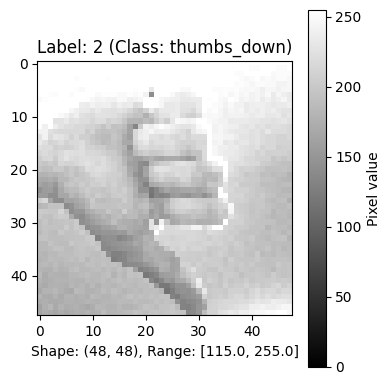

In [17]:
# Choose a sample (by index) in the training set
idx = 0

# Get the image and label
img = train_data[idx]
label = train_labels[idx]

# Plot the image
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {label} (Class: {class_names[label]})")
plt.xlabel(f"Shape: {img.shape}, Range: [{img.min()}, {img.max()}]")
plt.colorbar(label='Pixel value')
plt.tight_layout()
plt.show()

## Create a Custom Dataset and DataLoader

We need to wrap our dataset up in a custom Dataset class and provide a way for the training process to fetch samples in batches.

In [18]:
class ImageDataset(Dataset):
    """
    Custom PyTorch Dataset for image data
    """
    def __init__(self, data_list, labels_list):
        """
        Initialize the dataset
        """
        self.data = data_list
        self.labels = labels_list

    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample at index idx (as PyTorch tensors)
        """
        # Get the image: shape (H, W)
        image = self.data[idx]

        # Add channel dimension: (H, W) to (1, H, W)
        # PyTorch Conv2d expects (C, H, W) format
        image = np.expand_dims(image, axis=0)

        # Convert to PyTorch tensors
        x = torch.FloatTensor(image)
        y = torch.LongTensor([self.labels[idx]])[0]

        return x, y

In [19]:
# Wrap each dataset
train_dataset = ImageDataset(train_data, train_labels)
val_dataset = ImageDataset(val_data, val_labels)
test_dataset = ImageDataset(test_data, test_labels)

# Verify
x, y = train_dataset[0]
print(f"Sample shape: {x.shape}")
print(f"Sample dtype: {x.dtype}")
print(f"Label: {y} (Class: {class_names[y]})")

Sample shape: torch.Size([1, 48, 48])
Sample dtype: torch.float32
Label: 2 (Class: thumbs_down)


In [20]:
# Create a DataLoader for each of our splits
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Demonstrate how to get one batch from the training DataLoader
sample_batch_x, sample_batch_y = next(iter(train_loader))
print(f"Batch input shape: {sample_batch_x.shape}")
print(f"Batch labels shape: {sample_batch_y.shape}")

Batch input shape: torch.Size([32, 1, 48, 48])
Batch labels shape: torch.Size([32])


## Build Machine Learning Model

We're going to build a simple convolutional neural network (CNN).

In [87]:
class SimpleCNN(nn.Module):
    """
    Simple Convolutional Neural Network for image classification
    """
    def __init__(
        self,
        input_width,
        input_height,
        conv_1_num_filters,
        conv_2_num_filters,
        num_classes,
        dropout
    ):
        """
        Constructor that defines the CNN layers
        """
        super().__init__()

        # Store input dimensions for reference
        self.input_width = input_width
        self.input_height = input_height

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(
            1,
            conv_1_num_filters,
            kernel_size=3,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(conv_1_num_filters)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(
            conv_1_num_filters,
            conv_2_num_filters,
            kernel_size=3,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(conv_2_num_filters)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten output of convolution layers to 1D array
        self.flatten = nn.Flatten()

        # Fully connected layer (LazyLinear infers input size automatically)
        # One node for each class
        self.fc1 = nn.LazyLinear(num_classes)

    def forward(self, x):
        """
        Defines how data flows through the model
        """
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Fully connected layer
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [95]:
# Initialize the model
model = SimpleCNN(
    input_width=IMG_WIDTH,
    input_height=IMG_HEIGHT,
    conv_1_num_filters=CONV_1_NUM_FILTERS,
    conv_2_num_filters=CONV_2_NUM_FILTERS,
    num_classes=len(class_names),
    dropout=DROPOUT
)

# Move to device
model = model.to(device)

# Print model details
# Note: number of parameters unknown until we do a forward pass
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LazyLinear(in_features=0, out_features=4, bias=True)
)


In [96]:
# Loss function (measure how wrong the model's predictions are)
loss_fn = nn.CrossEntropyLoss()

# Optimizer (how to adjust the model's weights to reduce loss)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Model Training

We are now ready to train our model!

In [97]:
def train_one_epoch(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device
):
    """
    Train the model for one epoch
    """
    total_loss = 0.0
    num_correct = 0
    total_samples = 0

    # Enable training-specific behaviors (e.g. dropout)
    model.train()

    # Do one full training cycle on a batch of training data
    for batch_x, batch_y in dataloader:
        # Move data to the same device as the model
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)

        # Calculate loss
        loss = loss_fn(outputs, batch_y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Get total loss for the batch (loss.item() is the average)
        total_loss += loss.item() * batch_x.size(0)
        total_samples += batch_y.size(0)

        # Count how many predictions matched the true labels
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == batch_y).sum().item()

    # Calculate averages
    avg_loss = total_loss / total_samples
    accuracy = num_correct / total_samples

    return avg_loss, accuracy

In [98]:
def validate(model, dataloader, loss_fn, device):
    """
    Compute the loss and accuracy on a given dataset
    """
    total_loss = 0.0
    num_correct = 0
    total_samples = 0

    # Disable training-specific behaviors (e.g. dropout)
    model.eval()

    # Do not track gradients during validation
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            # Move data to the same device as the model
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_x)

            # Calculate loss
            loss = loss_fn(outputs, batch_y)

            # Get total loss for the batch (loss.item() is the average)
            total_loss += loss.item() * batch_x.size(0)
            total_samples += batch_y.size(0)

            # Count how many predictions matched the true labels
            _, predicted = torch.max(outputs, 1)
            num_correct += (predicted == batch_y).sum().item()

    # Calculate averages
    avg_loss = total_loss / total_samples
    accuracy = num_correct / total_samples

    return avg_loss, accuracy

In [99]:
# Lists to store metrics for plotting later
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device
    )

    # Validate
    val_loss, val_acc = validate(
        model,
        val_loader,
        loss_fn,
        device
    )

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print progress
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:6.2f}")

# Print model parameter count (now that LazyLinear is initialized)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Epoch [  1/100] | Train Loss: 1.3227 | Train Acc:   0.44 | Val Loss: 1.3692 | Val Acc:   0.44
Epoch [  2/100] | Train Loss: 1.0854 | Train Acc:   0.77 | Val Loss: 1.1562 | Val Acc:   0.64
Epoch [  3/100] | Train Loss: 0.9187 | Train Acc:   0.85 | Val Loss: 0.9684 | Val Acc:   0.78
Epoch [  4/100] | Train Loss: 0.7734 | Train Acc:   0.90 | Val Loss: 0.8034 | Val Acc:   0.86
Epoch [  5/100] | Train Loss: 0.6601 | Train Acc:   0.93 | Val Loss: 0.6874 | Val Acc:   0.88
Epoch [  6/100] | Train Loss: 0.5619 | Train Acc:   0.94 | Val Loss: 0.5775 | Val Acc:   0.90
Epoch [  7/100] | Train Loss: 0.4885 | Train Acc:   0.94 | Val Loss: 0.5058 | Val Acc:   0.91
Epoch [  8/100] | Train Loss: 0.4207 | Train Acc:   0.97 | Val Loss: 0.4490 | Val Acc:   0.93
Epoch [  9/100] | Train Loss: 0.3680 | Train Acc:   0.98 | Val Loss: 0.4048 | Val Acc:   0.93
Epoch [ 10/100] | Train Loss: 0.3205 | Train Acc:   0.97 | Val Loss: 0.3613 | Val Acc:   0.95
Epoch [ 11/100] | Train Loss: 0.2851 | Train Acc:   0.99 | V

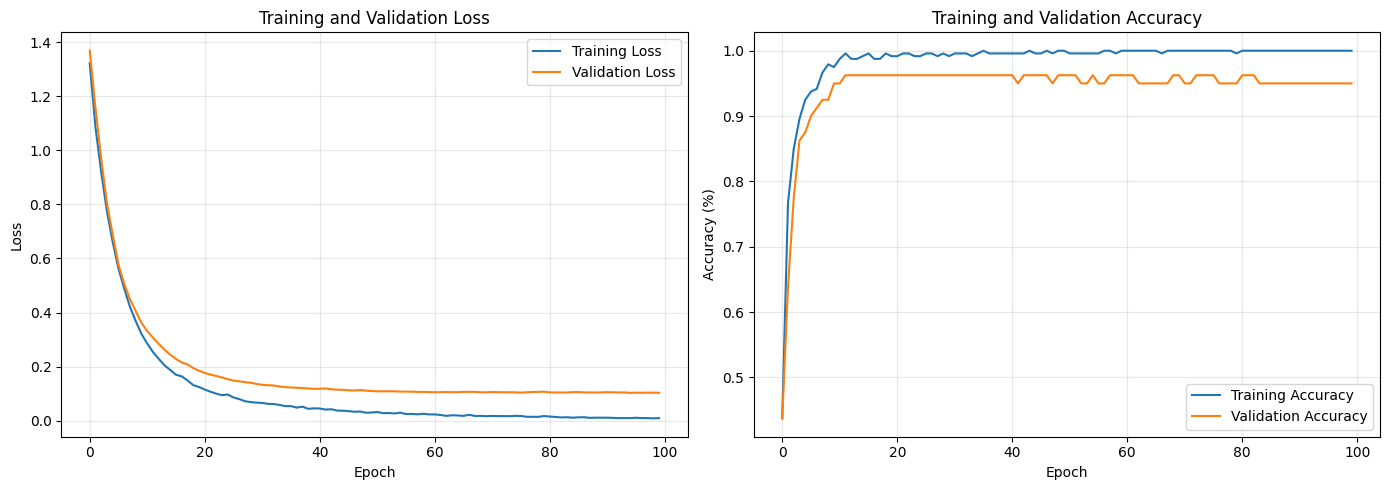

In [100]:
# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
ax1.plot(train_losses, label="Training Loss")
ax1.plot(val_losses, label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(train_accuracies, label="Training Accuracy")
ax2.plot(val_accuracies, label="Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Show plots
plt.tight_layout()
plt.show()

## Evaluate the Model

We use the holdout (test) dataset to see how well the model performs.

In [101]:
# Evaluate the model on our test set
test_loss, test_accuracy = validate(model, test_loader, loss_fn, device)

# Print out the results
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Loss: 0.026
Test Accuracy: 1.00


In [102]:
# Get all predictions and true labels from test set
all_predictions = []
all_labels = []

# Put model into evaluation mode
model.eval()

# Do not track gradients
with torch.no_grad():

    # Get batches of data from the test dataset loader
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Get predicted classes (max value of outputs)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)

        # Move predictions and labels to CPU
        all_predictions.extend(predicted.cpu())
        all_labels.extend(batch_y.cpu())

# Convert predictions and labels to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [103]:
# Create an empty array for our confusion matrix
num_classes = len(class_names)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Add the stats to the confusion matrix
for true_label, pred_label in zip(all_labels, all_predictions):
    conf_matrix[true_label, pred_label] += 1

# Print header
print("Confusion Matrix:")
print(f"{'True\\Pred':<12}", end="")
for class_name in class_names:
    print(f"{class_name:>12}", end="")
print()

# Print matrix with row labels
for i, class_name in enumerate(class_names):
    print(f"{class_name:<12}", end="")
    for j in range(num_classes):
        print(f"{conf_matrix[i, j]:>12}", end="")
    print()

Confusion Matrix:
True\Pred    _background      _other thumbs_down   thumbs_up
_background           25           0           0           0
_other                 0          15           0           0
thumbs_down            0           0          21           0
thumbs_up              0           0           0          19


In [104]:
# Calculate per-class accuracy
print("\nPer-Class Performance:")
print(f"  {'Class':<15} {'Correct':<10} {'Total':<10} {'Accuracy':<10}")
print(f"  {'-'*45}")

# Print per-class accuracies
for i, class_name in enumerate(class_names):
    correct = conf_matrix[i, i]  # Diagonal elements
    total = conf_matrix[i, :].sum()  # Sum of row
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"  {class_name:<15} {correct:<10} {total:<10} {accuracy:>6.2f}%")


Per-Class Performance:
  Class           Correct    Total      Accuracy  
  ---------------------------------------------
  _background     25         25         100.00%
  _other          15         15         100.00%
  thumbs_down     21         21         100.00%
  thumbs_up       19         19         100.00%


In [105]:
# Print header
print("Metrics per Class:")
print(f"  {'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"  {'-'*51}")

# Calculate per-class metrics
precisions = []
recalls = []
f1_scores = []
for i, class_name in enumerate(class_names):
    # True Positives
    tp = conf_matrix[i, i]

    # False Positives
    fp = conf_matrix[:, i].sum() - tp

    # False Negatives
    fn = conf_matrix[i, :].sum() - tp

    # Precision: TP / (TP + FP)
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0

    # Recall: TP / (TP + FN)
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    # F1 score: single metric that combines precision (accuracy of
    # positive predictions) and recall (completeness)
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    # Store metrics
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Print class metrics
    print(f"  {class_name:<15} {precision:>10.4f}  {recall:>10.4f}  {f1:>10.4f}")

# Calculate simple macro average across all classes
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1_scores)

# Print overall (average) metrics
print(f"  {'-'*51}")
print(f"  {'Macro Avg':<15} {macro_precision:>10.4f}  {macro_recall:>10.4f}  {macro_f1:>10.4f}")

# Calculate overall accuracy
overall_accuracy = np.trace(conf_matrix) / conf_matrix.sum() * 100
print(f"\n  {'Overall Accuracy':<15} {overall_accuracy:>6.2f}%")

Metrics per Class:
  Class           Precision    Recall       F1-Score    
  ---------------------------------------------------
  _background         1.0000      1.0000      1.0000
  _other              1.0000      1.0000      1.0000
  thumbs_down         1.0000      1.0000      1.0000
  thumbs_up           1.0000      1.0000      1.0000
  ---------------------------------------------------
  Macro Avg           1.0000      1.0000      1.0000

  Overall Accuracy 100.00%


## Single Sample Inference

Demonstrate how the model performs on a single sample.

Sample shape: torch.Size([1, 1, 48, 48])
Ground truth label: 1 (Class: _other)
Raw output (logits): [-12.352765    7.602535   -0.6783203  -8.928405 ]
Predicted class: 1


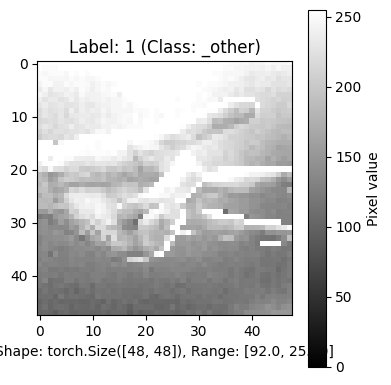

In [117]:
# Choose an index (in the test set)
idx = 3

# Get a sample
x, y = test_dataset[idx]

# Disable training features
model.eval()

# Add a batch dimension (the model expects it even if batch=1)
x_batch = x.unsqueeze(0)
print(f"Sample shape: {x_batch.shape}")

# Move data to the same device as the model
x_batch = x_batch.to(device)

# Run inference (no gradient tracking)
with torch.no_grad():
    output = model(x_batch)

# Show inference results
print(f"Ground truth label: {y} (Class: {class_names[y]})")
print(f"Raw output (logits): {output[0].cpu().numpy()}")
print(f"Predicted class: {torch.argmax(output[0]).item()}")

# Remove channel dimension for plotting: (1, H, W) to (H, W)
x_plot = x.squeeze(0)

# Plot the image
plt.figure(figsize=(4, 4))
plt.imshow(x_plot, cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {y} (Class: {class_names[y]})")
plt.xlabel(f"Shape: {x_plot.shape}, Range: [{x_plot.min()}, {x_plot.max()}]")
plt.colorbar(label='Pixel value')
plt.tight_layout()
plt.show()

## Export Model

Note that in most cases, the export process will produce 2 separate files:
* **.onnx** - Model architecture and metadata (with references to external weight data)
* **.onnx.data** - Model weights (external data file)

In [123]:
# Put the model into evaluation mode
model.eval()

# Create a dummy input tensor with the same shape as one sample (batch=1)
dummy_input = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)

# Export to ONNX
torch.onnx.export(
    model,                              # Model to export
    dummy_input,                        # Example input (for tracing)
    ONNX_PATH,                          # Output file path
    export_params=True,                 # Export with trained weights
    opset_version=ONNX_OPSET_VERSION,   # Which operations are supported
    do_constant_folding=True,           # Optimize constant operations
    input_names=['input'],              # Name for input layer
    output_names=['output']             # Name for output layer
)
print(f"Model exported to: {ONNX_PATH}")

[torch.onnx] Obtain model graph for `SimpleCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SimpleCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 2 of general pattern rewrite rules.
Model exported to: /content/model.onnx


## Export Calibration Data

Export a few samples from the validation set to act as calibration data for post-training quantization.

In [125]:
# Don't exceed the total number of available samples
num_samples = min(NUM_CALIB_SAMPLES, len(val_dataset))

# Randomly choose from validation set
indices = random.sample(range(len(val_dataset)), num_samples)

# Get samples (ignore the labels) and convert to NumPy arrays
calib_samples = []
for i in indices:
    x, _ = val_dataset[i]
    calib_samples.append(x.numpy())

# Stack into a single array: shape (num_samples, 1, H, W)
calib_data = np.stack(calib_samples, axis=0)

# Save samples as NPZ
np.savez(CALIB_NPZ_PATH, input=calib_data)
print(f"Calibration data shape: {calib_data.shape}")
print(f"Calibration data range: [{calib_data.min():.1f}, {calib_data.max():.1f}]")
print(f"Saved calibration data to: {CALIB_NPZ_PATH}")

Calibration data shape: (80, 1, 48, 48)
Calibration data range: [5.0, 255.0]
Saved calibration data to: /content/calibration_data.npz


## Generate Helper Code

We just need to remember our resolution and grayscale conversion coefficients.

In [128]:
c_code = f"""\
// Target image dimensions
#define IMG_WIDTH {IMG_WIDTH}
#define IMG_HEIGHT {IMG_HEIGHT}

// Grayscale conversion coefficients
#define GRAY_R_COEFF 0.299f
#define GRAY_G_COEFF 0.587f
#define GRAY_B_COEFF 0.114f
"""
print(c_code)

// Target image dimensions
#define IMG_WIDTH 48
#define IMG_HEIGHT 48

// Grayscale conversion coefficients
#define GRAY_R_COEFF 0.299f
#define GRAY_G_COEFF 0.587f
#define GRAY_B_COEFF 0.114f



## Test Inference Static Sample

Compare the output of inference from the original model and the quantized/deployed model on the embedded device.

In [129]:
# Choose a sample from the test set
idx = 0

# Get the sample
x, y = test_dataset[idx]

# Run inference to get expected output
model.eval()
x_batch = x.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(x_batch)
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(output[0]).item()

# Print expected results
print("Expected inference results:")
print(f"  True label: {y} ({class_names[y]})")
print(f"  Predicted: {predicted_class} ({class_names[predicted_class]})")
print(f"  Logits: {output[0].cpu().numpy()}")
print(f"  Probabilities: {probabilities[0].cpu().numpy()}")

Expected inference results:
  True label: 2 (thumbs_down)
  Predicted: 2 (thumbs_down)
  Logits: [-7.6819253 -3.58538    4.77197   -2.904419 ]
  Probabilities: [3.8997528e-06 2.3450085e-04 9.9929833e-01 4.6332090e-04]


In [135]:

# Get image as numpy array: (1, H, W) -> (H, W)
sample_img = x.squeeze(0).numpy().astype(np.uint8)

# Generate C array
print("\n// C array for test sample")
print(f"#define TEST_SAMPLE_WIDTH {IMG_WIDTH}")
print(f"#define TEST_SAMPLE_HEIGHT {IMG_HEIGHT}")
print(f"\nconst uint8_t test_sample[{IMG_HEIGHT} * {IMG_WIDTH}] = {{")

# Print pixel values in rows
pixels = sample_img.flatten()
for row in range(IMG_HEIGHT):
    start = row * IMG_WIDTH
    end = start + IMG_WIDTH
    row_values = ", ".join(f"{p:3d}" for p in pixels[start:end])
    comma = "," if row < IMG_HEIGHT - 1 else ""
    print(f"    {row_values}{comma}")

print("};")


// C array for test sample
#define TEST_SAMPLE_WIDTH 48
#define TEST_SAMPLE_HEIGHT 48

const uint8_t test_sample[48 * 48] = {
    255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
    255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 251, 255, 255, 255, 255, 251, 251, 251,
    255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 251, 253, 249, 251, 251, 247, 251, 247,
    255, 255, 255, 251, 247, 251, 249, 255, 253, 255, 251, 255, 247, 251, 251, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

## Deploy!

Download your *model.onnx* and *model.onnx.data* files. Use your vendor's toolset (e.g. RUHMI) to quantize, compress, and compile the model for your target device.